In [14]:
%matplotlib widget

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

def vec2(x,y):
    """
    Helper function for quickly creating 2D vectors without having to write too much text.
    """
    return np.array([x,y], dtype=np.float64)

In [16]:
class SimpleGrid2D:
    
    def __init__(self, min_coord, max_coord, I, J):
        if np.any(min_coord > max_coord):
            raise ValueError()
        if I < 2:
            raise ValueError()
        if J < 2:
            raise ValueError()

        self.min_coord = min_coord
        self.max_coord = max_coord
        
        self.I = I  # Number of nodes along x axis
        self.J = J  # Number of nodes along y axis
        
        res = np.array([I-1, J-1], dtype=np.float64)
        dims = (self.max_coord - self.min_coord)
        self.spacing = np.divide( dims, res)
        
        self.dx = self.spacing[0]
        self.dy = self.spacing[1]

        self.x = np.linspace(min_coord[0], max_coord[0], I)
        self.y = np.linspace(min_coord[1], max_coord[1], J)
    
        X, Y = np.meshgrid(self.x, self.y)
        self.X = X.T
        self.Y = Y.T
        self.values = np.zeros((I, J),dtype=np.float64)
        
    def interpolate(self, p):
        idx = np.floor((p - self.min_coord) / self.spacing)
        # if index is outside the cells then project onto closest cell
        i = np.clip(int(idx[0]), 0, self.I-2)
        j = np.clip(int(idx[1]), 0, self.J-2)
                
        x00 = self.values[i,j]
        x01 = self.values[i+1,j]
        x10 = self.values[i,j+1]
        x11 = self.values[i+1,j+1]
        
        s = (p[0]  - (i * self.spacing[0] + self.min_coord[0]) ) / self.spacing[0]
        t = (p[1]  - (j * self.spacing[1] + self.min_coord[1])) / self.spacing[1]        

        y0 = (x01 - x00) * s + x00
        y1 = (x11 - x10) * s + x10
        return (y1 - y0) * t + y0
    
    def eval_func(self, func):
        for i in range(self.I):
            for j in range(self.J):
                x = self.X[i,j]
                y = self.Y[i,j]
                self.values[i,j] = func(vec2(x,y))

In [17]:
def make_copy(grid):
    cpy = SimpleGrid2D(grid.min_coord, grid.max_coord, grid.I, grid.J)
    cpy.values = np.copy(grid.values)
    return cpy

def show_grid(grid):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title('Grid Values')
    plt.imshow(grid.values)
    ax.set_aspect('equal')
    plt.colorbar(orientation='vertical')
    plt.show()

def show_grid_3d(grid):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(grid.X, grid.Y, grid.values,
                    cmap="magma",
                    color='0.75',
                    rstride=1,
                    cstride=1,
                    antialiased=False)
    ax.set_aspect('auto')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Grid Values')
    plt.show()

In [18]:
def compute_signed_distance(poly, q):
    
    def is_left(p0, p1, p2):
        return (p1[0] - p0[0]) * (p2[1] - p0[1]) - (p2[0] - p0[0]) * (p1[1] - p0[1])

    N = poly.shape[0]
    d = np.inf

    # Compute distance to closest surface point
    for i in range(N-1):
        a = poly[i, :]    # Point on the surface of polygon p
        b = poly[i+1, :]  # Adjacent point on the surface of polygon p
        
        ba = b - a     # Vector from a to b
        bal = np.linalg.norm(ba) # Length of ba vector
        if bal == 0:
            continue
        ban = ba / bal # Normal of the vector from a to b
        qa = q - a     # The vector from the query point to a
        alpha = np.dot(qa, ban) / bal
        if alpha < 0:
            da = np.linalg.norm(q-a)
            if da < d:
                d = da
        elif alpha > 1:
            db = np.linalg.norm(q-b)
            if db < d:
                d = db
        else:
            banp = np.array([-ban[1], ban[0]])
            dp = abs(np.dot(qa, banp))
            if dp < d:
                d = dp
    # Compute winding number to set the sign
    wn = 0
    for i in range(N-1):
        a = poly[i, :]    # Point on the surface of polygon p
        b = poly[i+1, :]  # Adjacent point on the surface of polygon p
        if a[1] <= q[1]:
            if b[1] > q[1]:
                if is_left(a, b, q) > 0:
                    wn = wn + 1
        else:
            if b[1] <= q[1]:
                if is_left(a, b, q) < 0:
                    wn = wn -1
    if wn < -0.5:
        d = -d
    elif wn > 0.5:
        d = -d
    return d

In [19]:
def compute_mean_curvature(grid, ε = 0):
    κ = np.zeros((grid.I, grid.J), dtype=np.float64)
    κ_max = 1/max(grid.dx, grid.dy)
    
    #### COMPUTE INSIDE DOMAIN
    for j in range(1, grid.J - 1):
        for i in range(1, grid.I - 1):
            # Finite differences for first and second derivatives
            Dx = (grid.values[i+1, j] - grid.values[i-1, j]) / (2*grid.dx)
            Dy = (grid.values[i, j+1] - grid.values[i, j-1]) / (2*grid.dy)
            Dxx = (grid.values[i+1, j] - 2*grid.values[i, j] + grid.values[i-1, j]) / (grid.dx**2)
            Dyy = (grid.values[i, j+1] - 2*grid.values[i, j] + grid.values[i, j-1]) / (grid.dy**2)
            Dxy = (grid.values[i+1, j+1] - grid.values[i-1, j+1] - grid.values[i+1, j-1] + grid.values[i-1, j-1]) / (4*grid.dx*grid.dy)
            
            # Magnitude of the first order gradient
            g = np.sqrt(Dx**2 + Dy**2)
            if ε != 0:
                g += ε
            elif g < 1:
                g = 1
            
            # Approximation of mean curvature
            k = (Dx**2 * Dyy + Dy**2 * Dxx - 2*Dx*Dy*Dxy)/g**3
            κ[i, j] = np.clip(k, -κ_max, κ_max)
            
    return κ

To test our curvature field we must first create a grid instance that holds a signed distance field

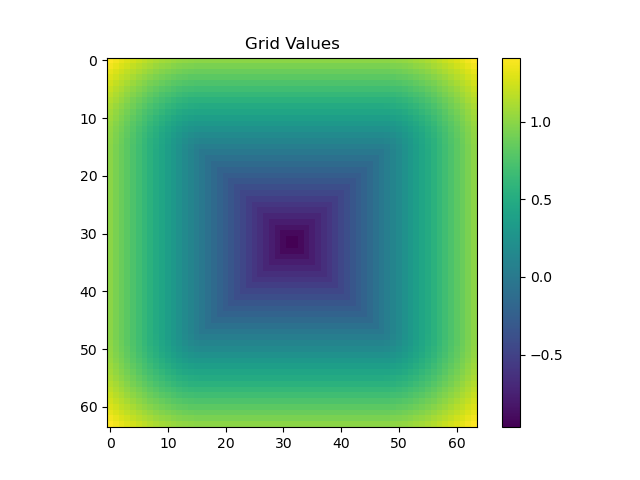

In [20]:
poly1 = np.zeros((5,2),dtype=np.float64)
poly1[0,:] = vec2(-1,-1)
poly1[1,:] = vec2( 1,-1)
poly1[2,:] = vec2( 1, 1)
poly1[3,:] = vec2(-1, 1)
poly1[4,:] = vec2(-1,-1)
        
min_coord = vec2(-2, -2)
max_coord = vec2(2, 2)
        
I = 64
J = I

grid_init = SimpleGrid2D(min_coord, max_coord, I, J)
grid_init.eval_func( lambda p: compute_signed_distance(poly1, p) )

# show_grid_3d(grid_init)
show_grid(grid_init)

In order to plot, let's save the curvature field we start with in another variable. We'll call it original. 

All pieces are now in place to setup the mean curvature flow main loop. This loop evolves the distance field using the mean curvature field as the speed function. Once we are done we plot contours of the original and the resulting distance fields to see the effect on the shape. 

In [21]:
def run_model(grid_init, T_init, C, ε = None):
    grid = make_copy(grid_init)
    κ_init = compute_mean_curvature(grid_init, ε)
    k_cfl = np.max(np.abs(κ_init))
    h = np.min([grid.dx, grid.dy])
    dt = C * h/(2*k_cfl)
    T = T_init
    while T > 0:
        cpy = make_copy(grid)
        κ = compute_mean_curvature(cpy, ε)
        cpy.values = cpy.values + dt*κ
        grid = cpy
        T = T - dt
        pDone = min(100, 100*(1-T/T_init))
        print(f"{pDone:.0f}% Done  ",end="\r")
    return grid

In [22]:
def plot_model(grid, grid_init, ε = None, filename = None):
    κ = compute_mean_curvature(grid, ε)
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].set_title(f'Mean curvature field from last iteration')
    axs[0].set_aspect('equal')
    axs[0].set_xlabel('i')
    axs[0].set_ylabel('j')
    im2 = axs[0].imshow(κ)
    cbar2 = fig.colorbar(im2, ax=axs[0], shrink = 0.5)
    
    axs[1].contour(grid_init.X, grid_init.Y, grid_init.values, [0.0], colors='r')
    axs[1].contour(grid.X, grid.Y, grid.values, [0.0], colors='b')
    axs[1].set_title('Contour comparison')
    axs[1].set_aspect('equal')
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('y')
    
    if filename != None:
        plt.savefig(filename)
    return fig, axs

def plot_model_large(grid, grid_init, T, C, ε = None, filename = None):
    κ_init = compute_mean_curvature(grid_init, ε)
    κ = compute_mean_curvature(grid, ε)
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    
    axs[0,0].set_title('$\phi$ after last iteration')
    axs[0,0].set_aspect('equal')
    im0 = axs[0,0].imshow(grid.values)
    cbar0 = fig.colorbar(im0, ax=axs[0,0], shrink = 0.7)
    cbar0.set_label('Signed distance field')

    axs[0,1].contour(grid_init.X, grid_init.Y, grid_init.values, [0.0], colors='r')
    axs[0,1].contour(grid.X, grid.Y, grid.values, [0.0], colors='b')
    axs[0,1].set_title('Contour comparison')
    axs[0,1].set_aspect('equal')
    axs[0,1].set_xlabel('x')
    axs[0,1].set_ylabel('y')

    axs[1,0].set_title('Mean curvature field from first iteration')
    axs[1,0].set_aspect('equal')
    axs[1,0].set_xlabel('i')
    axs[1,0].set_ylabel('j')
    im1 = axs[1,0].imshow(κ_init)
    cbar1 = fig.colorbar(im1, ax=axs[1,0], shrink = 0.7)
    cbar1.set_label('Mean curvature')
    axs[1,1].set_title(f'Mean curvature field from last iteration')
    axs[1,1].set_aspect('equal')
    axs[1,1].set_xlabel('i')
    axs[1,1].set_ylabel('j')
    im2 = axs[1,1].imshow(κ)
    cbar2 = fig.colorbar(im2, ax=axs[1,1], shrink = 0.5)
    
    if filename is not None:
        plt.savefig(filename)
    return fig, axs

In [23]:
doExp1: bool = False
doExp2: bool = False
doExp3: bool = True

In [24]:
if doExp1:
    min_coord = vec2(-2, -2)
    max_coord = vec2(2, 2)
            
    I = 64
    J = I

    grid_init = SimpleGrid2D(min_coord, max_coord, I, J)
    grid_init.eval_func( lambda p: compute_signed_distance(poly1, p) )

    # show_grid_3d(grid_init)
    show_grid(grid_init)

    Ts = [0.1, 0.5, 1]
    Cs = [0.25, 0.5]
    εs = [0, 0.1, 0.01]

    for T_init in Ts[::-1]:
        for C in Cs:
            for ε in εs:
                filename = f"mean_curvature_images/exp1_T_{T_init:.2f}_C_{C:.2f}_ε_{ε}.png"
                grid = run_model(grid_init, T_init, C, ε)
                fig, axs = plot_model(grid, grid_init, ε, filename)
                print(f"DONE: T = {T_init:.2f}, C = {C:.2f}, ε = {ε}")

In [25]:
if doExp2:
    
    T_init = 0.1
    C = 0.25
    ε = 0.05
    Is = [32, 64, 128]
    
    # filename = None
    
    for I in Is[::-1]:
        J = I
        grid_init = SimpleGrid2D(min_coord, max_coord, I, J)
        grid_init.eval_func( lambda p: compute_signed_distance(poly1, p))
        grid = run_model(grid_init, T_init, C, ε)
        filename = f"mean_curvature_images/exp2_I_{I}.png"
        fig, axs = plot_model(grid, grid_init, ε, filename)

DONE: Step 1/3
DONE: Step 2/3
DONE: Step 3/3


c:\Users\carla\.conda\envs\cmis\lib\site-packages\ipykernel_launcher.py:13: UserWarning: No contour levels were found within the data range.
  del sys.path[0]


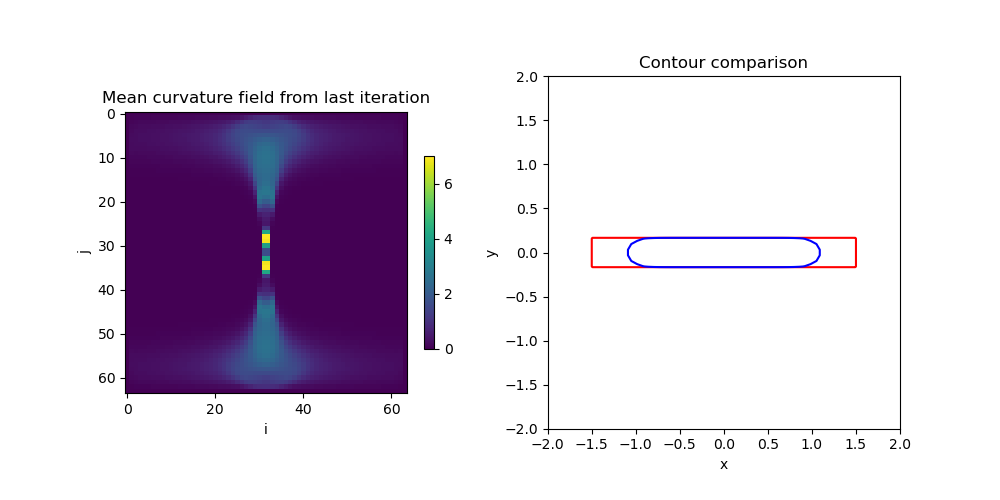

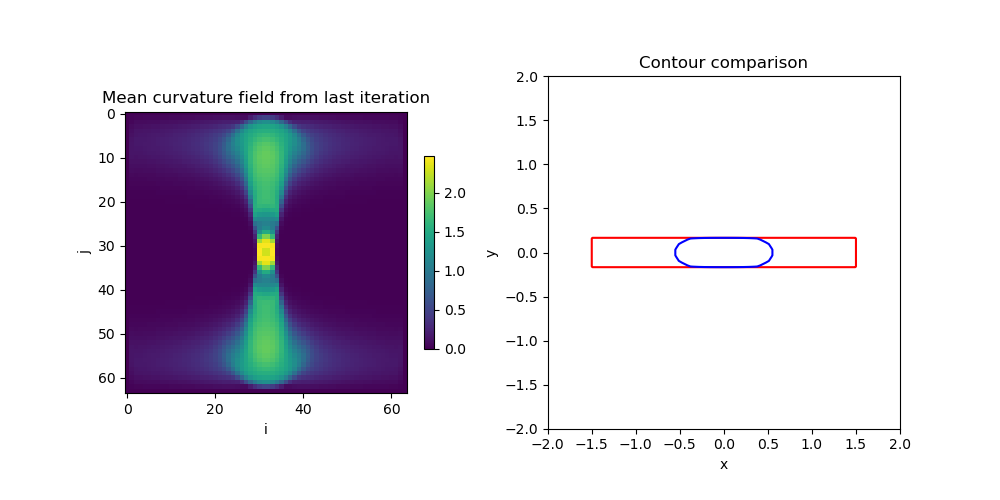

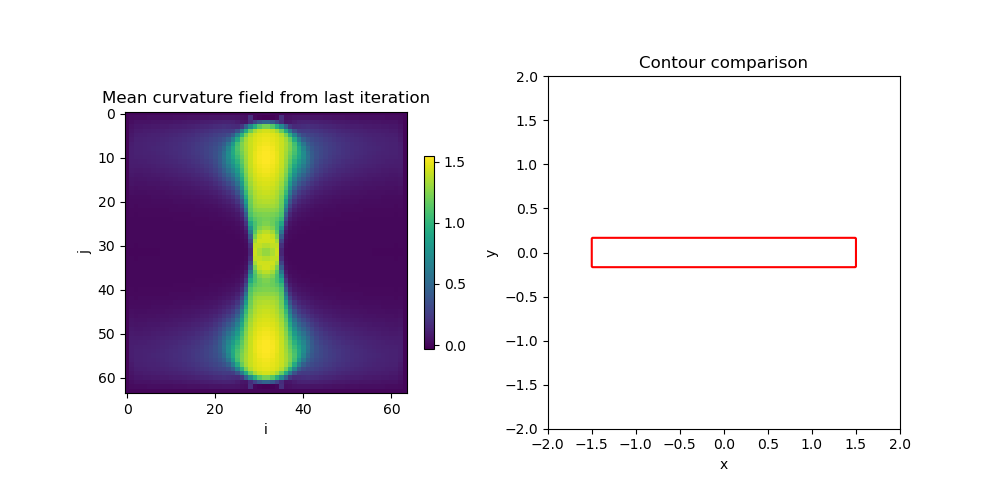

In [26]:
if doExp3:
    poly2 = np.zeros((5,2),dtype=np.float64)
    poly2[0,:] = vec2(-1.5, -1/6)
    poly2[1,:] = vec2( 1.5, -1/6)
    poly2[2,:] = vec2( 1.5,  1/6)
    poly2[3,:] = vec2(-1.5,  1/6)
    poly2[4,:] = vec2(-1.5, -1/6)
            
    min_coord = vec2(-2, -2)
    max_coord = vec2(2, 2)
            
    I = 64; J = I
    T_init = 0.1
    C = 0.1
    ε = 0.1

    grid_init = SimpleGrid2D(min_coord, max_coord, I, J)
    grid_init.eval_func( lambda p: compute_signed_distance(poly2, p) )

    grid = grid_init
    steps = 3
    for i in range(steps):
        grid = run_model(grid, T_init/steps + 0.01, C, ε)
        filename = f"mean_curvature_images/exp3_step_{i+1}.png"
        fig, axs = plot_model(grid, grid_init, ε, filename)
        print(f"DONE: Step {i+1}/{steps}")